In [1]:
import pandas as pd
import datetime


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# File location and type
file_location = "/FileStore/tables/energy.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_ = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df_)

NameError: name 'spark' is not defined

In [ ]:
# convert from spark 
df = df_.toPandas()
df

# check data types
print (df.dtypes)

# convert dates to datetime
df['Date']=pd.to_datetime(df['Date'])

#convert consumption to float
df['Consumption'] = df['Consumption'].astype(float)

#sort 
data = df.sort_values('Date')


In [ ]:
## add columns
data['Date_year'] = data['Date'].dt.year
data['Date_mth'] = data['Date'].dt.month
data['Date_week'] = data['Date'].dt.week
data['Date_wkday'] = data['Date'].dt.weekday
data['Date_yrday'] = data['Date'].dt.dayofyear


# create year group
data['Date_yeargrp'] = "Y1"
data['Date'] = pd.to_datetime(data['Date'])
data['Date_yeargrp']  = data.apply(lambda x: "Y2" if x['Date']>= datetime.datetime(2016,4, 1) else x['Date_yeargrp'], axis=1)
data['Date_yeargrp']  = data.apply(lambda x: "Y3" if x['Date']>= datetime.datetime(2017,4, 1) else x['Date_yeargrp'], axis=1)
data['Date_yeargrp']  = data.apply(lambda x: "Y4" if x['Date']>= datetime.datetime(2018,4, 1) else x['Date_yeargrp'], axis=1)
data['Date_yeargrp']  = data.apply(lambda x: "Y5" if x['Date']>= datetime.datetime(2019,4, 1) else x['Date_yeargrp'], axis=1)

# subsets
datasets = {}
datasets['data_years'] = list(data.Date_year.unique())
datasets['data_yrgrp'] = list(data.Date_yeargrp.unique())
datasets['data_mth'] = list(data.Date_mth.unique())
datasets['data_week'] = list(data.Date_week.unique())
datasets['data_wkday'] = list(data.Date_wkday.unique())
datasets['data_yrday'] = list(data.Date_yrday.unique())


for x in list(datasets.keys()):
    datasets[x].sort()

# day of the year group
data.sort_values(by=['Date'])
data['Date_yrday_yrgrp'] = data['Date_yrday']
data_list = []
for y in datasets['data_yrgrp']:
    data_sub = data[data["Date_yeargrp"] == y]
    data_sub['Date_yrday_yrgrp'] = list(range(1,len(data_sub)+1))
    data_list.append(data_sub)    
data = pd.concat(data_list)

#add index
#data["date_idx"] = data["Date"] 
#data= data.set_index('date_idx')

data

NameError: name 'data' is not defined

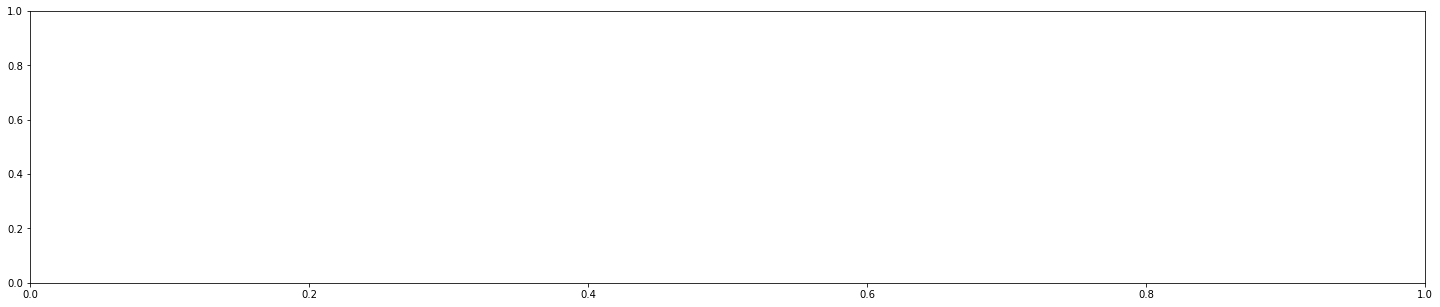

In [3]:
# Visualizations

## Raw data of time series
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(data.Date, data.Consumption, linewidth=1.5, linestyle='solid', color='red')
#ax.legend();
plt.title("Energy Demand - all")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.show()

# explore annual behaviour - chart suggests cyclical nature aka seasonality
fig, ax = plt.subplots(figsize=(25, 5))
for y in datasets['data_yrgrp']:
    plt.plot(data[data["Date_yeargrp"] == y].Date_yrday_yrgrp, data[data["Date_yeargrp"] == y].Consumption, linewidth=1, label = y)
plt.title("Energy Demand - year group")
plt.xlabel("Day of the year group")
plt.ylabel("Energy (MW)")
plt.legend()
plt.show()

# box plots to look at ranges & anomalities
import plotly.express as px
fig = px.box(data, x="Date_mth", y="Consumption", title = "All data - by month")
fig.show()
fig = px.box(data, x="Date_wkday", y="Consumption",title = "All data - by weekday ")
fig.show()

In [0]:
# 5 year groups of data - train with 3, validate with 1, test with 1
data['set']= 'Train'
data['set']  = data.apply(lambda x: "Validate" if x['Date_yeargrp']== "Y4" else x['set'], axis=1)
data['set']  = data.apply(lambda x: "Test" if x['Date_yeargrp']== "Y5" else x['set'], axis=1)
data_t = data[data["set"] == 'Train']
data_v = data[data["set"] == 'Validate']
data_t = data[data["set"] == 'Test']

#check that there is no skew in sampling
# Observed - test data has smaller ranges than training data
fig = px.box(data, x="Date_mth", y="Consumption",color="set",title = "By set - month")
fig.show()

fig = px.box(data, x="Date_wkday", y="Consumption",color="set",title = "By set - weekday")
fig.show()

In [0]:
end_train = data.index[data['Date'] == datetime.datetime(2018,3, 31)].tolist()[0]
end_validation = data.index[data['Date'] == datetime.datetime(2019,3, 31)].tolist()[0]
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

/databricks/python/lib/python3.8/site-packages/skforecast/utils/utils.py:256: UserWarning:

`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.

/databricks/python/lib/python3.8/site-packages/skforecast/utils/utils.py:256: UserWarning:

`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.

/databricks/python/lib/python3.8/site-packages/skforecast/utils/utils.py:256: UserWarning:

`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.

/databricks/python/lib/python3.8/site-packages/skforecast/utils/utils.py:256: UserWarning:

`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1461
Number of observations used for backtesting: 366
 Number of folds: 366
 Number of steps per fold: 1

Data partition in fold: 0
 Training: 0 -- 1460
 Validation: 1461 -- 1461
Data partition in fold: 1
 Training: 0 -- 1460
 Validation: 1462 -- 1462
Data partition in fold: 2
 Training: 0 -- 1460
 Validation: 1463 -- 1463
Data partition in fold: 3
 Training: 0 -- 1460
 Validation: 1464 -- 1464
Data partition in fold: 4
 Training: 0 -- 1460
 Validation: 1465 -- 1465
Data partition in fold: 5
 Training: 0 -- 1460
 Validation: 1466 -- 1466
Data partition in fold: 6
 Training: 0 -- 1460
 Validation: 1467 -- 1467
Data partition in fold: 7
 Training: 0 -- 1460
 Validation: 1468 -- 1468
Data partition in fold: 8
 Training: 0 -- 1460
 Validation: 1469 -- 1469
Data partition in fold: 9
 Training: 0 -- 1460
 Validation: 1470 -- 1470
Data partition in fold: 10
 Training: 0 -- 1460
 Validation: 1471 -- 1471
Data partition in fold: 11
 Training: 0 -- 1460
 Validation: 1472 -- 1472
Data partition in fold: 12
 Training: 0 -- 1460
 Validation: 1473 -- 1473
Data partition in fold: 13
 Training: 0 -- 1460
 Validation: 1474 -- 1474
Data partition in fold: 14
 Training: 0 -- 1460
 Validation: 1475 -- 1475
Data partition in fold: 15
 Training: 0 -- 1460
 Validation: 1476 -- 1476
Data partition in fold: 16
 Training: 0 -- 1460
 Validation: 1477 -- 1477
Data partition in fold: 17
 Training: 0 -- 1460
 Validation: 1478 -- 1478
Data partition in fold: 18
 Training: 0 -- 1460
 Validation: 1479 -- 1479
Data partition in fold: 19
 Training: 0 -- 1460
 Validation: 1480 -- 1480
Data partition in fold: 20
 Training: 0 -- 1460
 Validation: 1481 -- 1481
Data partition in fold: 21
 Training: 0 -- 1460
 Validation: 1482 -- 1482
Data partition in fold: 22
 Training: 0 -- 1460
 Validation: 1483 -- 1483
Data partition in fold: 23
 Training: 0 -- 1460
 Validation: 1484 -- 1484
Data partition in fold: 24
 Training: 0 -- 1460
 Validation: 1485 -- 1485
Data partition in fold: 25
 Training: 0 -- 1460
 Validation: 1486 -- 1486
Data partition in fold: 26
 Training: 0 -- 1460
 Validation: 1487 -- 1487
Data partition in fold: 27
 Training: 0 -- 1460
 Validation: 1488 -- 1488
Data partition in fold: 28
 Training: 0 -- 1460
 Validation: 1489 -- 1489
Data partition in fold: 29
 Training: 0 -- 1460
 Validation: 1490 -- 1490
Data partition in fold: 30
 Training: 0 -- 1460
 Validation: 1491 -- 1491
Data partition in fold: 31
 Training: 0 -- 1460
 Validation: 1492 -- 1492
Data partition in fold: 32
 Training: 0 -- 1460
 Validation: 1493 -- 1493
Data partition in fold: 33
 Training: 0 -- 1460
 Validation: 1494 -- 1494
Data partition in fold: 34
 Training: 0 -- 1460
 Validation: 1495 -- 1495
Data partition in fold: 35
 Training: 0 -- 1460
 Validation: 1496 -- 1496
Data partition in fold: 36
 Training: 0 -- 1460
 Validation: 1497 -- 1497
Data partition in fold: 37
 Training: 0 -- 1460
 Validation: 1498 -- 1498
Data partition in fold: 38
 Training: 0 -- 1460
 Validation: 1499 -- 1499
Data partition in fold: 39
 Training: 0 -- 1460
 Validation: 1500 -- 1500
Data partition in fold: 40
 Training: 0 -- 1460
 Validation: 1501 -- 1501
Data part

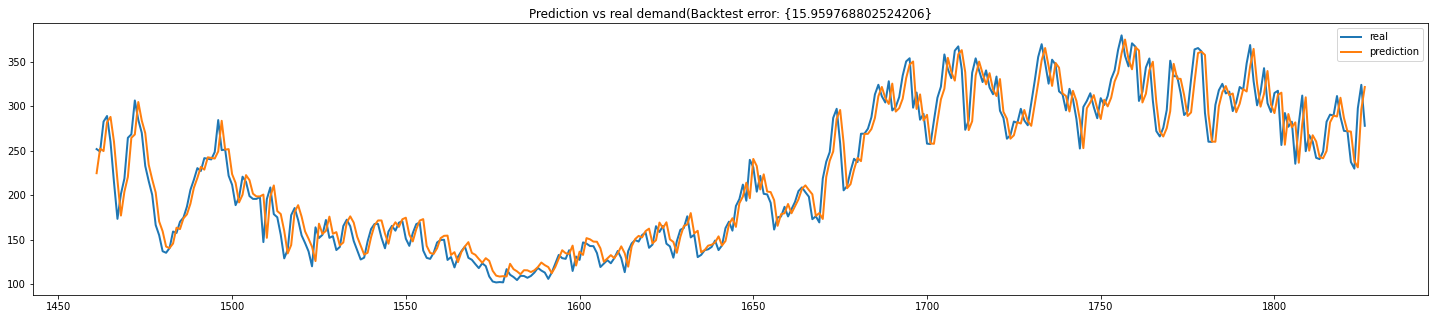

py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0

In [0]:
#Creating recursive autoregressive model
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from skforecast.model_selection import backtesting_forecaster


forecaster_Ar = ForecasterAutoreg(regressor = make_pipeline(StandardScaler(), Ridge()),lags= 1)
#forecaster_Ar.fit(y=data_train.loc[:,'Consumption'])
forecaster_Ar.fit(y=data.loc[:end_validation, 'Consumption'])

# Backtest
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster_Ar,
                            y          = data.Consumption,
                            initial_train_size = len(data.loc[:end_validation]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# reshape predictions df
idx=list(data[end_validation+1:].index)
idx
predictions_df = pd.DataFrame(list(predictions['pred']), columns=['Predictions'], index = idx)

#plot to compare
fig, ax = plt.subplots(figsize=(25, 5))
data.loc[predictions_df.index,'Consumption'].plot(ax=ax, linewidth=2, label='real')
predictions_df.loc[predictions_df.index, 'Predictions'].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand' + '(Backtest error: ' + str({metric}))
ax.legend();
plt.show()


In [0]:
data.loc[predictions_df.index, 'Date']

Out[9]: 1461 2019-04-01
1462 2019-04-02
1463 2019-04-03
1464 2019-04-04
1465 2019-04-05
 ... 
1822 2020-03-27
1823 2020-03-28
1824 2020-03-29
1825 2020-03-30
1826 2020-03-31
Name: Date, Length: 366, dtype: datetime64[ns]py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0

In [0]:
#Hyperparameter tuning with grid search

py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0

Out[11]:

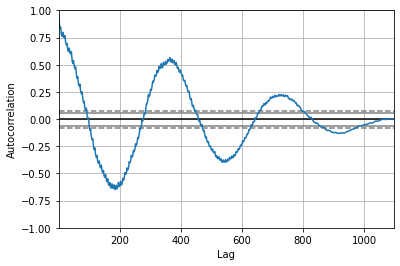

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_train.Consumption)


SARIMAX Results 
==============================================================================
Dep. Variable: Consumption No. Observations: 1096
Model: ARIMA(7, 1, 0) Log Likelihood -5170.398
Date: Tue, 13 Sep 2022 AIC 10356.796
Time: 01:00:27 BIC 10396.784
Sample: 0 HQIC 10371.927
 - 1096 
Covariance Type: opg 
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.L1 0.0773 0.025 3.140 0.002 0.029 0.126
ar.L2 -0.2375 0.029 -8.157 0.000 -0.295 -0.180
ar.L3 -0.1060 0.026 -4.018 0.000 -0.158 -0.054
ar.L4 -0.0819 0.025 -3.245 0.001 -0.131 -0.032
ar.L5 -0.1973 0.024 -8.124 0.000 -0.245 -0.150
ar.L6 -0.0127 0.027 -0.463 0.643 -0.067 0.041
ar.L7 0.2445 0.024 10.005 0.000 0.197 0.292
sigma2 740.2596 22.389 33.064 0.000 696.378 784.141
===================================================================================
Ljung-Box (L1) (Q): 0.68 Jarque-Bera (JB): 210.38
Prob(Q): 0.41 Prob(JB): 0.00
Heteroskedasticity (H): 1.57 Skew: -0.07
Prob(H) (two-sided): 0.00 Kurtosis: 5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

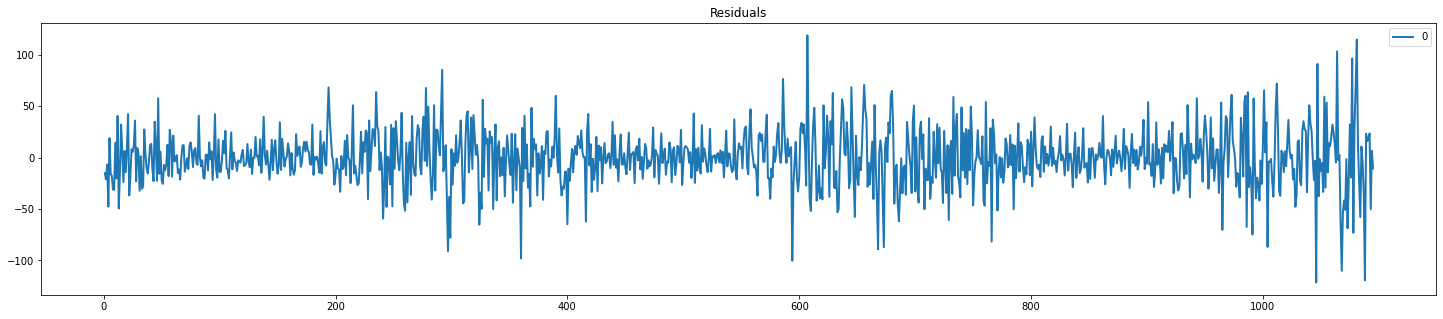

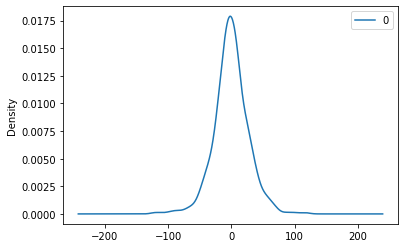

0
count 1095.000000
mean -0.094584
std 27.199474
min -121.531484
25% -14.768045
50% -0.476138
75% 14.466383
max 118.843372
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0

In [0]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

model = ARIMA(data_train.Consumption, order=(7,1,0)) #lag value to 7 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

#residuals plot
residuals = DataFrame(model_fit.resid)
residuals = residuals.iloc[1:]
fig, ax = plt.subplots(figsize=(25, 5))
residuals.plot(ax=ax, linewidth=2, label='residuals')
ax.set_title('Residuals')
ax.legend();
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [0]:
#- look at errors metrics of ARIMA model
#- optimize
#- evaluate production performance
#- compare with AR
#-add additional feature e.g temperature, holidays etc

py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0
py4j.java_gateway INFO Received command c on object id p0